In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!cp /content/drive/MyDrive/SAML-D.csv /content

In [3]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [5]:
df = pd.read_csv("/content/SAML-D.csv")
df.shape

(9504852, 12)

In [6]:
# The dataset has more than 9 million entries , for simplicity purpose we use only around 200k entries
df = df.sample(n=200000, random_state=1)
df.shape

(200000, 12)

In [7]:
# check for duplicates
df = df.drop_duplicates(keep = 'first')
df.shape

(200000, 12)

In [8]:
df.tail()

,Time,Date,Sender_account,Receiver_account,Amount,Payment_currency,Received_currency,Sender_bank_location,Receiver_bank_location,Payment_type,Is_laundering,Laundering_type
8606623,15:17:25,2023-07-23,7029921966,3828530251,5632.33,UK pounds,UK pounds,UK,UK,ACH,0,Normal_Plus_Mutual
6346650,11:37:07,2023-05-08,3518726122,9768510209,7214.17,UK pounds,UK pounds,UK,UK,ACH,0,Normal_Fan_In
8957570,18:28:26,2023-08-04,9456347626,1570347336,1940.43,UK pounds,UK pounds,UK,UK,Cheque,0,Normal_Small_Fan_Out
7654334,13:26:45,2023-06-21,5296246312,6172615079,6304.50,UK pounds,UK pounds,UK,UK,Debit card,0,Normal_Fan_In
9065824,13:04:39,2023-08-08,6517474457,8029865996,775.45,UK pounds,UK pounds,UK,UK,ACH,0,Normal_Small_Fan_Out


In [9]:
# Check for null or NaN values
print(df.isna().sum())

Time                      0
Date                      0
Sender_account            0
Receiver_account          0
Amount                    0
Payment_currency          0
Received_currency         0
Sender_bank_location      0
Receiver_bank_location    0
Payment_type              0
Is_laundering             0
Laundering_type           0
dtype: int64


In [10]:
# check for blank strings
print((df == '').sum())

Time                      0
Date                      0
Sender_account            0
Receiver_account          0
Amount                    0
Payment_currency          0
Received_currency         0
Sender_bank_location      0
Receiver_bank_location    0
Payment_type              0
Is_laundering             0
Laundering_type           0
dtype: int64


In [11]:
# Data types
print("\nData types:")
print(df.dtypes)


Data types:
Time                       object
Date                       object
Sender_account              int64
Receiver_account            int64
Amount                    float64
Payment_currency           object
Received_currency          object
Sender_bank_location       object
Receiver_bank_location     object
Payment_type               object
Is_laundering               int64
Laundering_type            object
dtype: object


In [12]:
# number of transactions per payment type
transactions_per_payment_type = df['Payment_type'].value_counts()

# number of laundering transactions per payment type
laundering_transactions_per_payment_type = df[df['Is_laundering'] == 1].groupby('Payment_type').size()

transactions_per_payment_type, laundering_transactions_per_payment_type

(Payment_type
 Cheque             42499
 Credit card        42413
 Debit card         42405
 ACH                42146
 Cross-border       19581
 Cash Withdrawal     6205
 Cash Deposit        4751
 Name: count, dtype: int64,
 Payment_type
 ACH                26
 Cash Deposit       31
 Cash Withdrawal    21
 Cheque             23
 Credit card        26
 Cross-border       49
 Debit card         19
 dtype: int64)

In [13]:
df['Sender_bank_location'].unique()

array(['UK', 'UAE', 'Morocco', 'Japan', 'Germany', 'Italy', 'France',
       'Mexico', 'Pakistan', 'Albania', 'Nigeria', 'Switzerland',
       'Turkey', 'Netherlands', 'USA', 'India', 'Austria', 'Spain'],
      dtype=object)

In [14]:
df.describe()

,Sender_account,Receiver_account,Amount,Is_laundering
count,2.000000e+05,2.000000e+05,200000.000000,200000.000000
mean,5.001152e+09,5.001039e+09,8750.761190,0.000975
std,2.887164e+09,2.882951e+09,21957.159439,0.031210
min,3.209500e+04,1.326600e+04,6.140000,0.000000
25%,2.498540e+09,2.512679e+09,2150.647500,0.000000
50%,4.994117e+09,4.996041e+09,6112.375000,0.000000
75%,7.505735e+09,7.489113e+09,10491.497500,0.000000
max,9.999987e+09,9.999958e+09,984679.650000,1.000000


In [15]:
laundering_stats = df[df['Is_laundering'] == 1]['Amount'].agg(['max', 'mean', 'min'])

normal_stats = df[df['Is_laundering'] == 0]['Amount'].agg(['max', 'mean', 'min'])

print("Laundering Transactions Stats:\n", laundering_stats)
print("\nNormal Transactions Stats:\n", normal_stats)

Laundering Transactions Stats:
 max     759709.070000
mean     17432.592045
min         29.070000
Name: Amount, dtype: float64

Normal Transactions Stats:
 max     984679.650000
mean      8742.288144
min          6.140000
Name: Amount, dtype: float64


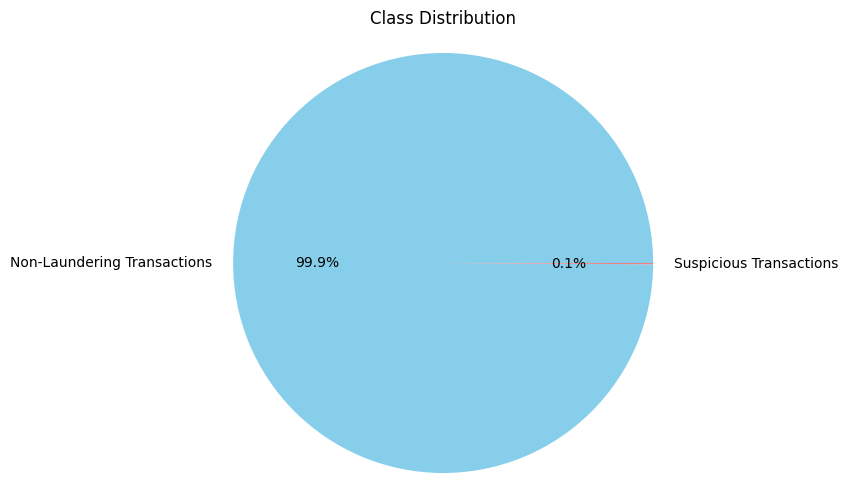

In [16]:
class_distribution = df['Is_laundering'].value_counts()

plt.figure(figsize=(10, 6))
plt.pie(class_distribution, labels=['Non-Laundering Transactions', 'Suspicious Transactions'], autopct='%1.1f%%', colors=['skyblue', 'lightcoral'])

plt.title('Class Distribution')
plt.axis('equal')

plt.show()

In [17]:
#handling imbalance in the dataset
#using SMOTE (Synthectic Monitory Over-sampling Technique)
from imblearn.over_sampling import SMOTE

In [18]:
# Check the initial class distribution
print("Initial class distribution:")
print(df['Is_laundering'].value_counts(normalize=True))

Initial class distribution:
Is_laundering
0    0.999025
1    0.000975
Name: proportion, dtype: float64


In [19]:
# Separate the features and the target
X = df.drop(columns=['Is_laundering'])
y = df['Is_laundering'] #target

In [20]:
# Convert time and date columns to datetime objects
X['Time'] = pd.to_datetime(X['Time'], format='%H:%M:%S')
X['Date'] = pd.to_datetime(X['Date'], format='%Y-%m-%d')

In [21]:
# Extract features from date if needed, here extracting year, month, day
X['Year'] = X['Date'].dt.year
X['Month'] = X['Date'].dt.month
X['Day'] = X['Date'].dt.day

In [22]:
# Extract features from date if needed, here extracting year, month, day
X['Hour'] = X['Time'].dt.hour
X['Minute'] = X['Time'].dt.minute
X['Second'] = X['Time'].dt.second

In [23]:
# Drop the original Date and Time columns
X = X.drop(columns=['Date', 'Time'])

In [24]:
#one hot encoding some columns
from sklearn.preprocessing import OneHotEncoder

In [25]:
# Identify categorical columns for one-hot encoding
categorical_columns = [
    'Payment_currency',
    'Received_currency',
    'Sender_bank_location',
    'Receiver_bank_location',
    'Payment_type',
    'Laundering_type'
]
# One-hot encode categorical variables
X = pd.get_dummies(X, columns=categorical_columns)

In [26]:
# Define the SMOTE model with the desired sampling strategy
#Is_landuring should have around 30% 1's
smote = SMOTE(sampling_strategy=0.3, random_state=42)

In [27]:
# Apply SMOTE to the dataset
X_resampled, y_resampled = smote.fit_resample(X, y)

In [28]:
data = pd.DataFrame(X_resampled, columns=X.columns)
data['Is_laundering'] = y_resampled

<ipython-input-28-13c180dc56b5>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['Is_laundering'] = y_resampled


In [29]:
# Check the new class distribution
print("New class distribution:")
print(data['Is_laundering'].value_counts(normalize=True))

New class distribution:
Is_laundering
0    0.769232
1    0.230768
Name: proportion, dtype: float64


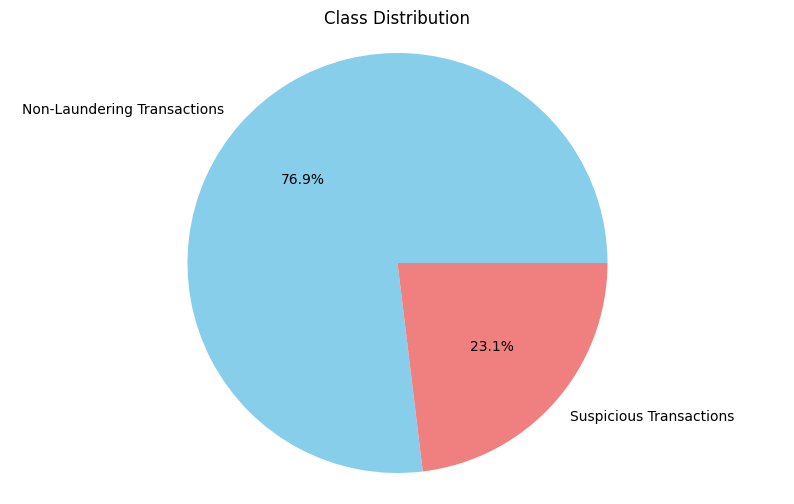

In [30]:
class_distribution = data['Is_laundering'].value_counts()

plt.figure(figsize=(10, 6))
plt.pie(class_distribution, labels=['Non-Laundering Transactions', 'Suspicious Transactions'], autopct='%1.1f%%', colors=['skyblue', 'lightcoral'])

plt.title('Class Distribution')
plt.axis('equal')

plt.show()

In [31]:
# Data types
print("\nData types:")
print(data.dtypes)


Data types:
Sender_account                         int64
Receiver_account                       int64
Amount                               float64
Year                                   int32
Month                                  int32
                                      ...   
Laundering_type_Single_large            bool
Laundering_type_Smurfing                bool
Laundering_type_Stacked Bipartite       bool
Laundering_type_Structuring             bool
Is_laundering                          int64
Length: 106, dtype: object


In [32]:
data.head()

,Sender_account,Receiver_account,Amount,Year,Month,Day,Hour,Minute,Second,Payment_currency_Albanian lek,...,Laundering_type_Normal_Periodical,Laundering_type_Normal_Plus_Mutual,Laundering_type_Normal_Small_Fan_Out,Laundering_type_Normal_single_large,Laundering_type_Scatter-Gather,Laundering_type_Single_large,Laundering_type_Smurfing,Laundering_type_Stacked Bipartite,Laundering_type_Structuring,Is_laundering
0,4248061080,9527052910,13480.74,2023,8,14,2,8,46,False,...,False,True,False,False,False,False,False,False,False,0
1,9130896737,908371799,10480.05,2023,7,2,19,48,23,False,...,False,False,False,False,False,False,False,False,False,0
2,1466348255,8545558838,26232.35,2023,7,22,12,4,24,False,...,False,False,False,False,False,False,False,False,False,0
3,2181923623,6234034932,447.07,2022,10,28,17,8,2,False,...,False,False,True,False,False,False,False,False,False,0
4,8596132461,3638213339,1005.62,2023,2,21,22,44,17,False,...,False,False,True,False,False,False,False,False,False,0


In [33]:
data.columns[59]

'Receiver_bank_location_Japan'

In [34]:
#creating high_risk_countries column
# List of high-risk countries
high_risk_countries = {"Nigeria", "Morocco", "Turkey", "Pakistan", "Mexico", "Spain"}
# Identify one-hot encoded columns for high-risk countries
sender_columns = [f"Sender_bank_location_{country}" for country in high_risk_countries]
receiver_columns = [f"Receiver_bank_location_{country}" for country in high_risk_countries]

In [35]:
# Check if any of the sender or receiver columns indicate a high-risk country
data['high_risk_countries'] = data[sender_columns + receiver_columns].sum(axis=1).apply(lambda x: 1 if x > 0 else 0)

<ipython-input-35-8903bdb6223a>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['high_risk_countries'] = data[sender_columns + receiver_columns].sum(axis=1).apply(lambda x: 1 if x > 0 else 0)


In [36]:
data.head()

,Sender_account,Receiver_account,Amount,Year,Month,Day,Hour,Minute,Second,Payment_currency_Albanian lek,...,Laundering_type_Normal_Plus_Mutual,Laundering_type_Normal_Small_Fan_Out,Laundering_type_Normal_single_large,Laundering_type_Scatter-Gather,Laundering_type_Single_large,Laundering_type_Smurfing,Laundering_type_Stacked Bipartite,Laundering_type_Structuring,Is_laundering,high_risk_countries
0,4248061080,9527052910,13480.74,2023,8,14,2,8,46,False,...,True,False,False,False,False,False,False,False,0,0
1,9130896737,908371799,10480.05,2023,7,2,19,48,23,False,...,False,False,False,False,False,False,False,False,0,0
2,1466348255,8545558838,26232.35,2023,7,22,12,4,24,False,...,False,False,False,False,False,False,False,False,0,0
3,2181923623,6234034932,447.07,2022,10,28,17,8,2,False,...,False,True,False,False,False,False,False,False,0,0
4,8596132461,3638213339,1005.62,2023,2,21,22,44,17,False,...,False,True,False,False,False,False,False,False,0,0


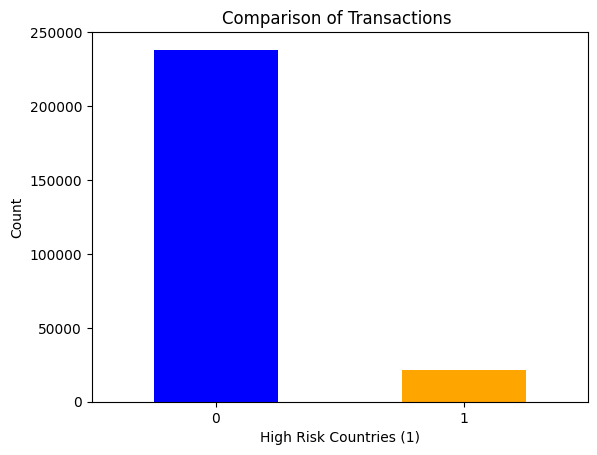

In [37]:
counts = data['high_risk_countries'].value_counts()

# Plotting the counts
counts.plot(kind='bar', color=['blue', 'orange'])
plt.xlabel('High Risk Countries (1)')
plt.ylabel('Count')
plt.title('Comparison of Transactions ')
plt.xticks([0, 1], ['0', '1'], rotation=0)
plt.show()

#Building Time Series Models

#RNN

In [38]:
#splitting dataset into features(x) and  target(y)
X = data[['Day', 'Month', 'Year', 'Hour', 'Minute', 'Second']]
y = data['Is_laundering']

In [39]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [41]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [42]:
predictions = model.predict(X_test)

In [43]:
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy}")

Accuracy: 0.988065294389405


In [44]:
print("Classification Report:")
print(classification_report(y_test, predictions))

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     59862
           1       0.97      0.98      0.97     18062

    accuracy                           0.99     77924
   macro avg       0.98      0.99      0.98     77924
weighted avg       0.99      0.99      0.99     77924



In [45]:
#confusion matrix
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
cm = confusion_matrix(y_test, predictions)

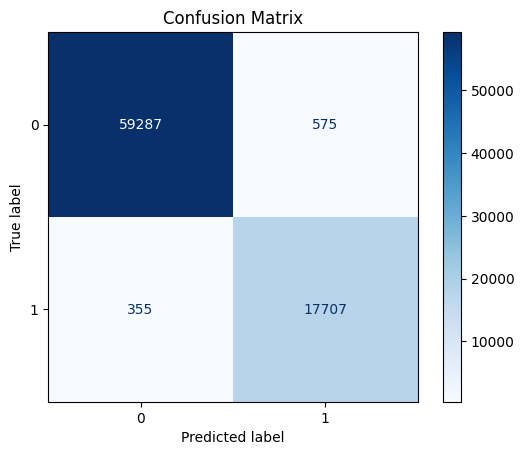

In [46]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

#LSTM

In [47]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [48]:
# Assuming X and y are already defined from previous steps
X= X = data[['Year', 'Month', 'Day', 'Hour', 'Minute', 'Second']].values
y = data['Is_laundering'].values
# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scale the data (optional but recommended for neural networks)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape data for LSTM input: (samples, time steps, features)
# Assuming X_train and X_test have shapes (samples, features)
X_train_reshaped = X_train_scaled.reshape(X_train_scaled.shape[0], 1, X_train_scaled.shape[1])
X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])

In [49]:
model = Sequential()

# LSTM layer with dropout
model.add(LSTM(units=50, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(units=1, activation='sigmoid'))  # Assuming binary classification

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print summary of the model
print(model.summary())

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 50)                  │          11,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,451 (44.73 KB)

 Trainable params: 11,451 (44.73 KB)

 Non-trainable params: 0 (0.00 B)

None


In [51]:
# Define early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Fit the model
history = model.fit(X_train_reshaped, y_train, epochs=20, batch_size=32,
                    validation_data=(X_test_reshaped, y_test), callbacks=[early_stop])

Epoch 1/20
5682/5682 ━━━━━━━━━━━━━━━━━━━━ 46s 7ms/step - accuracy: 0.8297 - loss: 0.4141 - val_accuracy: 0.8493 - val_loss: 0.3381
Epoch 2/20
5682/5682 ━━━━━━━━━━━━━━━━━━━━ 87s 8ms/step - accuracy: 0.8478 - loss: 0.3469 - val_accuracy: 0.8487 - val_loss: 0.3314
Epoch 3/20
5682/5682 ━━━━━━━━━━━━━━━━━━━━ 45s 8ms/step - accuracy: 0.8477 - loss: 0.3391 - val_accuracy: 0.8494 - val_loss: 0.3270
Epoch 4/20


KeyboardInterrupt: 

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test_reshaped, y_test)
print(f"Test Accuracy: {accuracy}")

# Make predictions
# Assuming model.predict(X_test_reshaped) returns probabilities or logits
predictions = model.predict(X_test_reshaped)

# Convert predictions to class labels
predicted_classes = (predictions > 0.5).astype(int)  # Example threshold of 0.5, adjust as needed

# Print classification report or any other evaluation metric
print(classification_report(y_test, predicted_classes))


# Plot accuracy and loss over epochs
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test_reshaped, y_test)
print(f"Test Accuracy: {accuracy}")

# Make predictions
# Assuming model.predict(X_test_reshaped) returns probabilities or logits
predictions = model.predict(X_test_reshaped)

# Convert predictions to class labels
predicted_classes = (predictions > 0.5).astype(int)  # Example threshold of 0.5, adjust as needed

# Print classification report or any other evaluation metric
print(classification_report(y_test, predicted_classes))


# Plot accuracy and loss over epochs
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Assuming predictions and y_test are already defined as per the previous code
predictions = (model.predict(X_test_reshaped) > 0.5).astype(int)

# Calculate confusion matrix
cm = confusion_matrix(y_test, predictions)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

#GRU

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.optimizers import Adam

In [ ]:
#splitting dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

In [ ]:
model = Sequential()
model.add(GRU(50, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]), return_sequences=True))
model.add(GRU(50))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(X_train_reshaped, y_train, epochs=10, batch_size=64, validation_split=0.2, verbose=2)

In [ ]:
loss, accuracy = model.evaluate(X_test_reshaped, y_test, verbose=0)
print(f'Test Accuracy: {accuracy}')

In [ ]:
predictions = (model.predict(X_test_reshaped) > 0.5).astype(int)

In [ ]:
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

#ARIMAX MODEL

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
model = SARIMAX(y_train, exog=X_train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
arimax_model = model.fit(disp=False)

In [ ]:
predictions = arimax_model.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, exog=X_test)

In [ ]:
predictions_binary = (predictions > 0.5).astype(int)

In [ ]:
accuracy = accuracy_score(y_test, predictions_binary)
print(f"Accuracy: {accuracy}")

In [ ]:
cm = confusion_matrix(y_test, predictions_binary)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

Anamolies Detection

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,LabelEncoder
from sklearn.impute import SimpleImputer

In [ ]:
data.dtypes

In [ ]:
import pandas as pd



# Identify boolean columns and convert them to integers
bool_columns = data.select_dtypes(include=['bool', 'object']).columns

for col in bool_columns:
    # Convert boolean-like object columns to actual boolean type first
    if data[col].dtype == 'object':
        data[col] = data[col].map({'True': True, 'False': False, 'true': True, 'false': False})



    # Convert boolean columns to integers
    data[col] = data[col].astype(int)

In [ ]:
if data['Is_laundering'].isna().sum() > 0:
    data = data.dropna(subset=['Is_laundering'])

In [ ]:
X = data.drop(columns=['Is_laundering'])
y = data['Is_laundering']

In [ ]:
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

In [ ]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

XG BOOST MODEL

In [ ]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix , ConfusionMatrixDisplay ,  classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#This is for fitting the data and training it on the sets
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train, y_train)

In [ ]:
y_train_pred = xgb_model.predict(X_train)
y_test_pred = xgb_model.predict(X_test)

In [ ]:
#This is for finding out how many of the predictions are accurate.
accuracy_train = accuracy_score(y_train, y_train_pred)
accuracy_test = accuracy_score(y_test, y_test_pred)
print(f"Accuracy (Training Set): {accuracy_train:.4f}")
print(f"Accuracy (Testing Set): {accuracy_test:.4f}")

In [ ]:
cm_train = confusion_matrix(y_train, y_train_pred)
print("\nConfusion Matrix (Training Set):\n", cm_train)

In [ ]:
cm_test = confusion_matrix(y_test, y_test_pred)
print("\nConfusion Matrix (Testing Set):\n", cm_test)

In [ ]:
# Plotting confusion matrix for testing set
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', cbar=False,
            annot_kws={'size': 14}, linewidths=0.5, linecolor='black')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Testing Set)')
plt.show()

#Random Forest Model

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [ ]:
#Initialising the model
rf_model = RandomForestClassifier(random_state=42)

In [ ]:
# Train the model
rf_model.fit(X_train, y_train)

In [ ]:
# Predictions on training and testing sets
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)

In [ ]:
#Calculating the accuracy
accuracy_train = accuracy_score(y_train, y_train_pred)
accuracy_test = accuracy_score(y_test, y_test_pred)
print(f"Accuracy (Training Set): {accuracy_train:.4f}")
print(f"Accuracy (Testing Set): {accuracy_test:.4f}")

In [ ]:
cm_train = confusion_matrix(y_train, y_train_pred)
print("\nConfusion Matrix (Training Set):\n", cm_train)

In [ ]:
cm_test = confusion_matrix(y_test, y_test_pred)
print("\nConfusion Matrix (Testing Set):\n", cm_test)

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', cbar=False,
            annot_kws={'size': 14}, linewidths=0.5, linecolor='black')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Testing Set)')
plt.show()

In [ ]:
#Classification report for the testing set
print("\nClassification Report (Testing Set):\n", classification_report(y_test, y_test_pred))

#CATBOOST MODEL

In [ ]:
!pip install catboost

In [ ]:
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [ ]:
cat_model = CatBoostClassifier(iterations=1000,  # Number of trees (iterations)
                           learning_rate=0.1,  # Learning rate
                           depth=6,  # Depth of trees
                           random_state=42,  # Random state for reproducibility
                           verbose=0)

In [ ]:
cat_model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50, verbose=100)

In [ ]:
y_train_pred = cat_model.predict(X_train)
y_test_pred = cat_model.predict(X_test)

In [ ]:
accuracy_train = accuracy_score(y_train, y_train_pred)
accuracy_test = accuracy_score(y_test, y_test_pred)
print(f"Accuracy (Training Set): {accuracy_train:.4f}")
print(f"Accuracy (Testing Set): {accuracy_test:.4f}")

In [ ]:
cm_train = confusion_matrix(y_train, y_train_pred)
print("\nConfusion Matrix (Training Set):\n", cm_train)

In [ ]:
cm_test = confusion_matrix(y_test, y_test_pred)
print("\nConfusion Matrix (Testing Set):\n", cm_test)

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', cbar=False,
            annot_kws={'size': 14}, linewidths=0.5, linecolor='black')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Testing Set)')
plt.show()

In [ ]:
print("\nClassification Report (Testing Set):\n", classification_report(y_test, y_test_pred))

#ISOLATED FOREST

In [ ]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
isf_model = IsolationForest(random_state=42, contamination='auto')

In [ ]:
# Train the model
isf_model.fit(X_train)

In [ ]:
# Predictions on training and testing sets
y_train_pred = isf_model.predict(X_train)
y_test_pred = isf_model.predict(X_test)

In [ ]:
## Convert predictions to binary labels: 1 (normal) and -1 (anomaly)
y_train_pred_binary = [1 if x == 1 else 0 for x in y_train_pred]
y_test_pred_binary = [1 if x == 1 else 0 for x in y_test_pred]

In [ ]:
cm_train = confusion_matrix(y_train, y_train_pred_binary)
print("\nConfusion Matrix (Training Set):\n", cm_train)

In [ ]:
cm_test = confusion_matrix(y_test, y_test_pred_binary)
print("\nConfusion Matrix (Testing Set):\n", cm_test)

In [ ]:
# Plotting confusion matrix for testing set
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', cbar=False,
            annot_kws={'size': 14}, linewidths=0.5, linecolor='black')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Testing Set)')
plt.show()

In [ ]:
# Classification report for testing set
print("\nClassification Report (Testing Set):\n", classification_report(y_test, y_test_pred_binary))

#Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
# Define Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42)

In [ ]:
dt_model.fit(X_train, y_train)

In [ ]:
# Predictions on training and testing sets
y_train_pred = dt_model.predict(X_train)
y_test_pred = dt_model.predict(X_test)

In [ ]:
# Calculate accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"\nTraining Accuracy: {train_accuracy:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")

In [ ]:
cm_train = confusion_matrix(y_train, y_train_pred)
print("\nConfusion Matrix (Training Set):\n", cm_train)

In [ ]:
cm_test = confusion_matrix(y_test, y_test_pred)
print("\nConfusion Matrix (Testing Set):\n", cm_test)

In [ ]:
# Plotting confusion matrix for testing set
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', cbar=False,
            annot_kws={'size': 14}, linewidths=0.5, linecolor='black')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Testing Set)')
plt.show()

In [ ]:
# Classification report for testing set
print("\nClassification Report (Testing Set):\n", classification_report(y_test, y_test_pred))

#Implimentation of Autoencoder Model

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.optimizers import Adam

In [ ]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
if np.isnan(X_scaled).any() or np.isinf(X_scaled).any():
    print("Scaled data contains NaN or Infinite values")

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [ ]:
input_dim = X_train.shape[1]
encoding_dim = 8

In [ ]:
input_layer = Input(shape=(input_dim,))

In [ ]:
#we have created 3 layers to improve the encoding accuracy
encoder = Dense(64, activation='relu', kernel_initializer='he_normal')(input_layer)
encoder = Dense(32, activation='relu', kernel_initializer='he_normal')(encoder)
encoded = Dense(encoding_dim, activation='relu', kernel_initializer='he_normal')(encoder)
decoder = Dense(32, activation='relu', kernel_initializer='he_normal')(encoded)
decoder = Dense(64, activation='relu', kernel_initializer='he_normal')(decoder)
decoded = Dense(input_dim, activation='sigmoid')(decoder)

In [ ]:
autoencoder = Model(inputs=input_layer, outputs=decoded)

In [ ]:
autoencoder.summary()

In [ ]:
optimizer = Adam(learning_rate=0.0001)
autoencoder.compile(optimizer=optimizer, loss='mean_squared_error')

In [ ]:
history=autoencoder.fit(X_train, X_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(X_test, X_test))

In [ ]:
# Visualize the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
encoder_model = Model(inputs=input_layer, outputs=encoded)

In [ ]:
encoded_data = encoder_model.predict(X_scaled)

In [ ]:
if np.isnan(encoded_data).any() or np.isinf(encoded_data).any():
    print("Encoded data contains NaN or Infinite values")

In [ ]:
encoded_features_df = pd.DataFrame(encoded_data, columns=[f'Encoded_Feature_{i+1}' for i in range(encoding_dim)])

In [ ]:
new_dataset = pd.concat([encoded_features_df, y.reset_index(drop=True)], axis=1)

In [ ]:
autoencoder.save('autoencoder_model.h5')
encoder_model.save('encoder_model.h5')

In [ ]:
print(new_dataset.head())

Now that we reduced our columns to 8 columns , we will impliment CAT BOOST , XGB and other anomalies detection model to the autoencoded columns

xgboost

In [ ]:
from sklearn.preprocessing import MinMaxScaler,LabelEncoder
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [ ]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix , ConfusionMatrixDisplay ,  classification_report
import matplotlib.pyplot as plt
import seaborn as sns
#This is for fitting the data and training it on the sets
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train, y_train)

In [ ]:
y_train_pred = xgb_model.predict(X_train)
y_test_pred = xgb_model.predict(X_test)
#This is for finding out how many of the predictions are accurate.
accuracy_train = accuracy_score(y_train, y_train_pred)
accuracy_test = accuracy_score(y_test, y_test_pred)
print(f"Accuracy (Training Set): {accuracy_train:.4f}")
print(f"Accuracy (Testing Set): {accuracy_test:.4f}")
cm_train = confusion_matrix(y_train, y_train_pred)
print("\nConfusion Matrix (Training Set):\n", cm_train)
cm_test = confusion_matrix(y_test, y_test_pred)
print("\nConfusion Matrix (Testing Set):\n", cm_test)

In [ ]:
# Plotting confusion matrix for testing set
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', cbar=False,
            annot_kws={'size': 14}, linewidths=0.5, linecolor='black')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Testing Set)')
plt.show()
# Classification report for testing set
print("\nClassification Report (Testing Set):\n", classification_report(y_test, y_test_pred))

random forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [ ]:
#Initialising the model
rf_model = RandomForestClassifier(random_state=42)

In [ ]:
# Train the model
rf_model.fit(X_train, y_train)

In [ ]:
#Predictions on training and testing set
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)

In [ ]:
#Calculating the accuracy
accuracy_train = accuracy_score(y_train, y_train_pred)
accuracy_test = accuracy_score(y_test, y_test_pred)
print(f"Accuracy (Training Set): {accuracy_train:.4f}")
print(f"Accuracy (Testing Set): {accuracy_test:.4f}")

In [ ]:
cm_train = confusion_matrix(y_train, y_train_pred)
print("\nConfusion Matrix (Training Set):\n", cm_train)

In [ ]:
cm_test = confusion_matrix(y_test, y_test_pred)
print("\nConfusion Matrix (Testing Set):\n", cm_test)

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', cbar=False,
            annot_kws={'size': 14}, linewidths=0.5, linecolor='black')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Testing Set)')
plt.show()

In [ ]:
#Classification report for the testing set
print("\nClassification Report (Testing Set):\n", classification_report(y_test, y_test_pred))

CATBOOST MODEL

In [ ]:
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
cat_model = CatBoostClassifier(iterations=1000,  # Number of trees (iterations)
                           learning_rate=0.1,  # Learning rate
                           depth=6,  # Depth of trees
                           random_state=42,  # Random state for reproducibility
                           verbose=0)
cat_model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50, verbose=100)

In [ ]:
y_train_pred = cat_model.predict(X_train)
y_test_pred = cat_model.predict(X_test)
accuracy_train = accuracy_score(y_train, y_train_pred)
accuracy_test = accuracy_score(y_test, y_test_pred)
print(f"Accuracy (Training Set): {accuracy_train:.4f}")
print(f"Accuracy (Testing Set): {accuracy_test:.4f}")

In [ ]:
cm_train = confusion_matrix(y_train, y_train_pred)
print("\nConfusion Matrix (Training Set):\n", cm_train)

In [ ]:
cm_test = confusion_matrix(y_test, y_test_pred)
print("\nConfusion Matrix (Testing Set):\n", cm_test)

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', cbar=False,
            annot_kws={'size': 14}, linewidths=0.5, linecolor='black')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Testing Set)')
plt.show()

In [ ]:
print("\nClassification Report (Testing Set):\n", classification_report(y_test, y_test_pred))

#Isolated Forest Model

In [ ]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix, classification_report
isf_model = IsolationForest(random_state=42, contamination='auto')
# Train the model
isf_model.fit(X_train)

In [ ]:
# Predictions on training and testing sets
y_train_pred = isf_model.predict(X_train)
y_test_pred = isf_model.predict(X_test)
## Convert predictions to binary labels: 1 (normal) and -1 (anomaly)
y_train_pred_binary = [1 if x == 1 else 0 for x in y_train_pred]
y_test_pred_binary = [1 if x == 1 else 0 for x in y_test_pred]
cm_train = confusion_matrix(y_train, y_train_pred_binary)
print("\nConfusion Matrix (Training Set):\n", cm_train)

In [ ]:
cm_test = confusion_matrix(y_test, y_test_pred_binary)
print("\nConfusion Matrix (Testing Set):\n", cm_test)

In [ ]:
# Plotting confusion matrix for testing set
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', cbar=False,
            annot_kws={'size': 14}, linewidths=0.5, linecolor='black')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Testing Set)')
plt.show()

In [ ]:
# Classification report for testing set
print("\nClassification Report (Testing Set):\n", classification_report(y_test, y_test_pred_binary))

Decision Trees

In [ ]:

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report
# Define Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

In [ ]:
# Predictions on training and testing sets
y_train_pred = dt_model.predict(X_train)
y_test_pred = dt_model.predict(X_test)
# Calculate accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"\nTraining Accuracy: {train_accuracy:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")

In [ ]:
cm_train = confusion_matrix(y_train, y_train_pred)
print("\nConfusion Matrix (Training Set):\n", cm_train)

In [ ]:
cm_test = confusion_matrix(y_test, y_test_pred)
print("\nConfusion Matrix (Testing Set):\n", cm_test)

In [ ]:
# Plotting confusion matrix for testing set
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', cbar=False,
            annot_kws={'size': 14}, linewidths=0.5, linecolor='black')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Testing Set)')
plt.show()

In [ ]:
# Classification report for testing set
print("\nClassification Report (Testing Set):\n", classification_report(y_test, y_test_pred))